##Setup

In [2]:
from torchvision import transforms
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import os
from matplotlib import pyplot as plt
from PIL import Image
import requests


In [ ]:
import pyarrow as pa
import pyarrow.parquet as pq
%pip install datasets

##Loading the Dataset

In [5]:
from datasets import load_dataset
import shutil

#dataset = load_dataset("vikhyatk/synthetic-pepe")

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 504
    })
})


Found 306 files belonging to 2 classes.


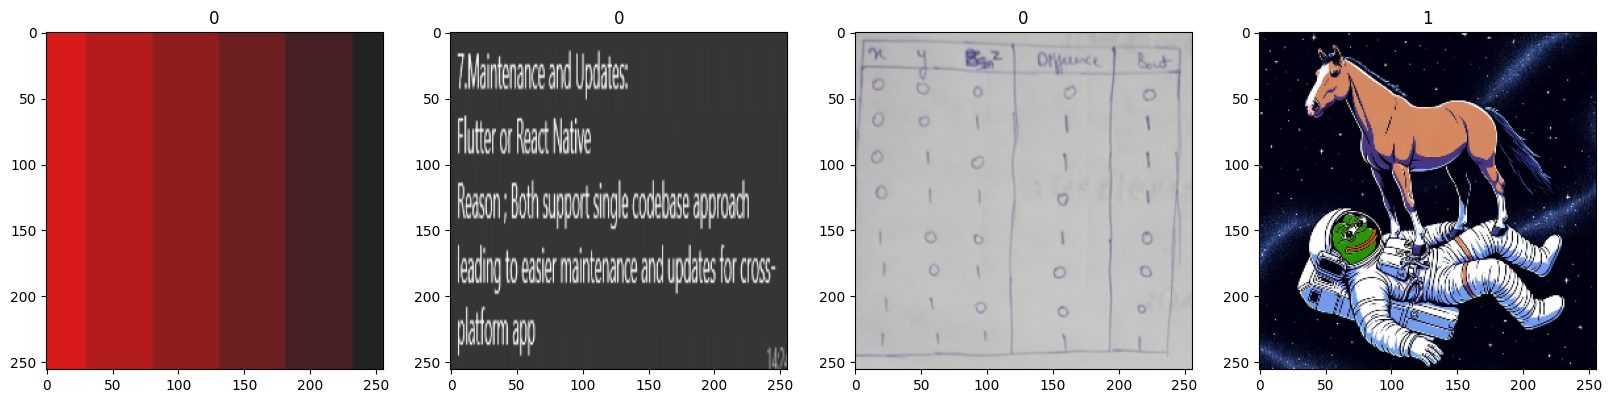

In [6]:
pepecheck = tf.keras.utils.image_dataset_from_directory('pepecheck')


data_iterator = pepecheck.as_numpy_iterator()

batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])



##Scaling the data

In [7]:
pepecheck = pepecheck.map(lambda x,y: (x/255, y))

pepecheck.as_numpy_iterator().next()



(array([[[[9.0784311e-01, 5.6176472e-01, 9.0490198e-01],
          [9.4509804e-01, 6.1078429e-01, 9.5784312e-01],
          [9.0490198e-01, 6.0000002e-01, 9.3431371e-01],
          ...,
          [9.9019605e-01, 6.9215685e-01, 8.6666667e-01],
          [9.7745097e-01, 6.8921566e-01, 8.5196078e-01],
          [9.9411762e-01, 7.1372551e-01, 8.7058824e-01]],
 
         [[5.3725493e-01, 1.7450981e-01, 5.9705883e-01],
          [7.6862746e-01, 3.3627450e-01, 8.0000001e-01],
          [7.9705882e-01, 4.2352942e-01, 8.3529413e-01],
          ...,
          [9.9509805e-01, 6.9313723e-01, 8.7058824e-01],
          [9.8725492e-01, 6.9117647e-01, 8.5686272e-01],
          [9.9607843e-01, 7.0784312e-01, 8.6666667e-01]],
 
         [[6.0980392e-01, 1.9411765e-01, 6.2549019e-01],
          [6.3823527e-01, 1.7745098e-01, 6.7352939e-01],
          [5.9019607e-01, 2.6862746e-01, 6.7745095e-01],
          ...,
          [9.9901962e-01, 6.9117647e-01, 8.7254900e-01],
          [9.8627448e-01, 6.8235296e-

##Splitting into training, testing and validation sets


In [8]:
train_size = int(len(pepecheck)*.7)
val_size = int(len(pepecheck)*.15)
test_size = int(len(pepecheck)*.15)

train_size



7

In [9]:
train = pepecheck.take(train_size)
val = pepecheck.skip(train_size).take(val_size)
test = pepecheck.skip(train_size+val_size).take(test_size)

##Model building

In [10]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [11]:
model = Sequential()

In [12]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

In [13]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

##Training the model

In [15]:
logdir='logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])



Epoch 1/20
7/7 [==============================] - 11s 519ms/step - loss: 1.0419 - accuracy: 0.5804 - val_loss: 0.6077 - val_accuracy: 0.6875
Epoch 2/20
7/7 [==============================] - 5s 487ms/step - loss: 0.5996 - accuracy: 0.7366 - val_loss: 0.4813 - val_accuracy: 0.8125
Epoch 3/20
7/7 [==============================] - 6s 575ms/step - loss: 0.4096 - accuracy: 0.8616 - val_loss: 0.3386 - val_accuracy: 0.8125
Epoch 4/20
7/7 [==============================] - 5s 423ms/step - loss: 0.3155 - accuracy: 0.8839 - val_loss: 0.3497 - val_accuracy: 0.8125
Epoch 5/20
7/7 [==============================] - 5s 416ms/step - loss: 0.1906 - accuracy: 0.9375 - val_loss: 0.1461 - val_accuracy: 0.9375
Epoch 6/20
7/7 [==============================] - 6s 426ms/step - loss: 0.1457 - accuracy: 0.9509 - val_loss: 0.2641 - val_accuracy: 0.8750
Epoch 7/20
7/7 [==============================] - 6s 594ms/step - loss: 0.1063 - accuracy: 0.9464 - val_loss: 0.0791 - val_accuracy: 1.0000
Epoch 8/20
7/7 [===

##Performance plots

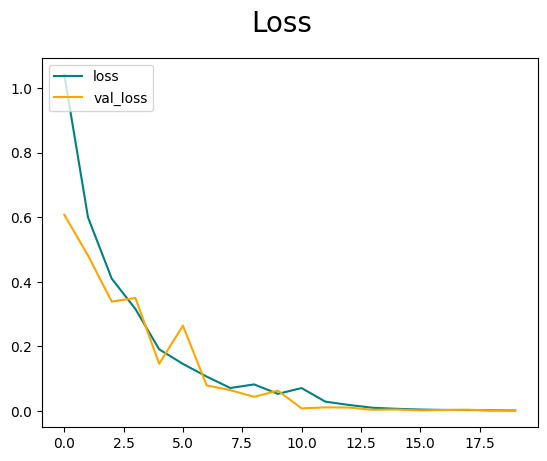

In [16]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

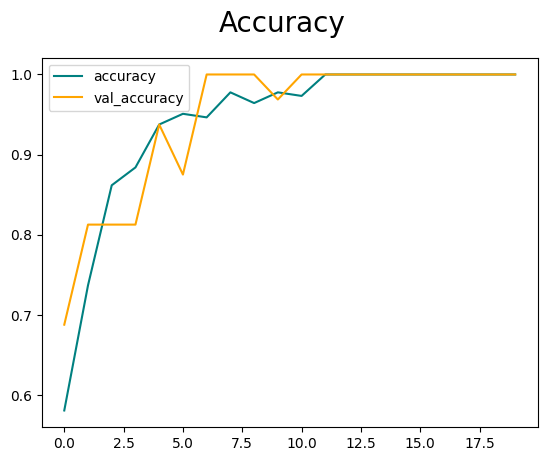

In [17]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

##Evaluation

In [18]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    ycap = model.predict(X)
    pre.update_state(y, ycap)
    re.update_state(y, ycap)
    acc.update_state(y, ycap)

print(pre.result(), re.result(), acc.result())



1/1 [==============================] - 0s 154ms/step
tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


##Testing

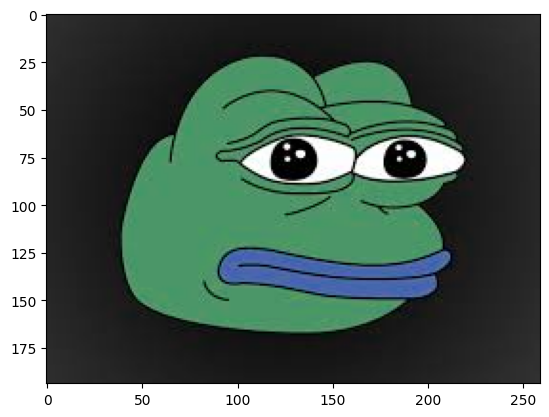

In [19]:
import cv2

img = cv2.imread('pepelol.jpeg')
plt.imshow(img) #cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.show()



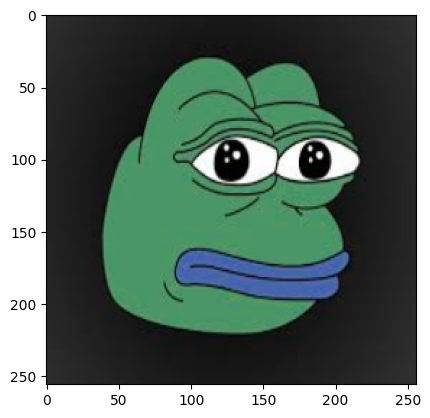

In [20]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [21]:
ycap = model.predict(np.expand_dims(resize/255, 0))

ycap



1/1 [==============================] - 0s 258ms/step


array([[0.46267977]], dtype=float32)

In [22]:
if ycap > 0.5:
    print(f'No pepe found :(')
else:
    print(f'Pepe found :)')

Pepe found :)
